The code in this notebok was based on the work of Eldave93 avialable at https://github.com/Eldave93/Seizure-Detection-Tutorials . The code was used to answer questions different from the original study. 

# Environment Set-up

First lets set up our notebook environment with the packages we need. If you are following along on Google Colab, then this will install the packages you will need.



In [ ]:
#@title

!pip install matplotlib pandas numpy scipy seaborn mne
!pip install beautifulsoup4 requests wget
!pip install h5py tables kaggle
!pip install wfdb pyEDFlib

In [13]:
# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

plot_kwargs = {
    'scalings': dict(eeg=20e-5),   # zooms the plot out
    'highpass': 0.5,              # filters out low frequencies
    'lowpass': 70.,                # filters out high frequencies
    'show_scrollbars': False,
    'show': True
}

print(color.BOLD+color.UNDERLINE+'Title'+color.END)

Title


# CHB-MIT Scalp EEG Database

1.   Elemento de lista
2.   Elemento de lista



The CHB-MIT dataset<sup>1</sup>, consists of records from 23 patients; with one case (chb21) taken from the same patient (chb01) 1.5 years later. The dataset was collected by investigators at the Children’s Hospital Boston and Massachusetts Institute of Technology (MIT). The median length of collection was for 36 hours with small gaps between records each hour due to hardware limitations.

The data contains 198 seizures of various types (focal, lateral, and generalised seizures). All signals were recorded at 256 samples per second with most files containing 23 EEG signals positioned using the International 10-20 system (as we will see later). 

This dataset is one of the most prominent datasets in the literature, as it provides long, continuous recordings for each patient, allowing for both patient specific and patient general models to be developed and tested.


| Subject   | Age/Gender | Seizure Events | Total Ictal Time (secs) | Total Inter-ictal Time (secs) |
|-----------|------------|----------------|------------------|----------------------|
| chb01/chb21 | 11, 13 (F) | 11 | 641  | 263461 |
| chb02       | 11 (M)     | 3  | 172  | 126751 |
| chb03       | 14 (F)     | 7  | 402  | 136366 |
| chb04       | 22 (M)     | 4  | 378  | 561414 |
| chb05       | 7 (F)      | 5  | 558  | 139813 |
| chb06       | 1.5 (F)    | 10 | 153  | 240075 |
| chb07       | 14.5 (F)   | 3  | 325  | 241044 |
| chb08       | 3.5 (M)    | 5  | 919  | 71084  |
| chb09       | 10 (F)     | 4  | 276  | 244043 |
| chb10       | 3 (M)      | 7  | 447  | 179612 |
| chb11       | 12 (F)     | 3  | 806  | 124416 |
| chb12       | 2 (F)      | 27 | 989  | 73466  |
| chb13       | 3 (F)      | 12 | 535  | 118232 |
| chb14       | 9 (F)      | 8  | 169  | 93405  |
| chb15       | 16 (M)     | 20 | 1992 | 142004 |
| chb16       | 7 (F)      | 10 | 84   | 68297  |
| chb17       | 12 (F)     | 3  | 293  | 75310  |
| chb18       | 18 (F)     | 6  | 317  | 127932 |
| chb19       | 19 (F)     | 3  | 236  | 107480 |
| chb20       | 6 (F)      | 8  | 294  | 99043  |
| chb22       | 9 (F)      | 3  | 204  | 111376 |
| chb23       | 6 (F)      | 7  | 424  | 95177  |
| chb24       | NR (NR)    | 16 | 511  | 76134  |
| **Total**   | -          | **185**| **11125**| **3515935**|

**NOTE**
- You may have noticed that in the table above it actually only totals to 185 seizures. Thats because the method I use to load the data into Python does not work on a select few files. This reduces the number of seizure events from 40 to 27 in patient 12 by not including files 27, 28, and 29.

---
1. Shoeb2009

# Data Information

In [ ]:
import wfdb 

dbs = wfdb.get_dbs()

records_list = wfdb.io.get_record_list('chbmit', records='all')
part_codes = sorted(list(set([record.split('/')[0] for record in records_list])))
import os
from urllib.request import urlretrieve

def get_content(part_code):
  url = "https://physionet.org/physiobank/database/chbmit/"+part_code+'/'+part_code+'-summary.txt'
  filename = "./chbmit.txt"

  urlretrieve(url,filename)

  # read the file into a list
  with open(filename, encoding='UTF-8') as f:
      # read all the document into a list of strings (each line a new string)
      content = f.readlines()
      os.remove(filename)

  return content

get_content(part_codes[2])

Taking the above, the below function below just parses this file up into a Python dictionary format we can use later. See the output for an example of what it looks like.

In [6]:
import re
part_info_dict = {}

def info_dict(content):
  
  line_nos=len(content)
  line_no=1

  channels = []
  file_name = []
  file_info_dict={}

  for line in content:

    # if there is Channel in the line...
    if re.findall('Channel \d+', line):
      # split the line into channel number and channel reference
      channel = line.split(': ')
      # get the channel reference and remove any new lines
      channel = channel[-1].replace("\n", "")
      # put into the channel list
      channels.append(channel)

    # if the line is the file name
    elif re.findall('File Name', line):
      # if there is already a file_name
      if file_name:
        # flush the current file info to it
        part_info_dict[file_name] = file_info_dict

      # get the file name
      file_name = re.findall('\w+\d+_\d+|\w+\d+\w+_\d+', line)[0]

      file_info_dict = {}
      # put the channel list in the file info dict and remove duplicates
      file_info_dict['Channels'] = list(set(channels))
      # reset the rest of the options
      file_info_dict['Start Time'] = ''
      file_info_dict['End Time'] = ''
      file_info_dict['Seizures Window'] = []

    # if the line is about the file start time
    elif re.findall('File Start Time', line):
      # get the start time
      file_info_dict['Start Time'] = re.findall('\d+:\d+:\d+', line)[0]

    # if the line is about the file end time
    elif re.findall('File End Time', line):
      # get the start time
      file_info_dict['End Time'] = re.findall('\d+:\d+:\d+', line)[0]

    elif re.findall('Seizure Start Time|Seizure End Time|Seizure \d+ Start Time|Seizure \d+ End Time', line):
      file_info_dict['Seizures Window'].append(int(re.findall('\d+', line)[-1]))

    # if last line in the list...
    if line_no == line_nos:
      # flush the file info to it
      part_info_dict[file_name] = file_info_dict

    line_no+=1
    
        
for part_code in part_codes:
  content = get_content(part_code)
  info_dict(content)


print(color.BOLD+color.UNDERLINE+'part_info_dict'+color.END)
display(part_info_dict['chb01_18'])
print(color.UNDERLINE+'\nPart Keys'+color.END)
print(part_info_dict[list(part_info_dict.keys())[0]].keys())

part_info_dict


{'Channels': ['T8-P8',
  'F7-T7',
  'CZ-PZ',
  'F8-T8',
  'C4-P4',
  'FP1-F3',
  'T7-P7',
  'T7-FT9',
  'P3-O1',
  'P7-T7',
  'FT10-T8',
  'FP1-F7',
  'P8-O2',
  'F3-C3',
  'FP2-F4',
  'F4-C4',
  'P4-O2',
  'FZ-CZ',
  'FT9-FT10',
  'P7-O1',
  'C3-P3',
  'FP2-F8'],
 'Start Time': '04:45:06',
 'End Time': '5:45:06',
 'Seizures Window': [1720, 1810]}


Part Keys
dict_keys(['Channels', 'Start Time', 'End Time', 'Seizures Window'])


As can be seen below there is a common set of channels found in ALL patients, but there are also some channels only found in individual patients. This is because sometimes channels were swapped during recording for others.

In [7]:
import pandas as pd     # dataframes
import re

all_channels = []

for key in part_info_dict.keys():
    all_channels.extend(part_info_dict[key]['Channels'])
    
# turn the list into a pandas series
all_channels = pd.Series(all_channels)

# count how many times the channels appear in each participant
channel_counts = all_channels.value_counts()
channel_counts

T8-P8      675
P8-O2      675
FP2-F8     675
C3-P3      675
P7-O1      675
          ... 
FP1         13
P7          13
F7          13
CZ          13
LOC-ROC     11
Length: 87, dtype: int64

In [8]:
threshold = len(part_info_dict.keys())
channel_keeps = list(channel_counts[channel_counts >= threshold].index)
channel_keeps

['T8-P8',
 'P8-O2',
 'FP2-F8',
 'C3-P3',
 'P7-O1',
 'FZ-CZ',
 'P4-O2',
 'F4-C4',
 'FP2-F4',
 'F3-C3',
 'FP1-F7',
 'P3-O1',
 'T7-P7',
 'FP1-F3',
 'C4-P4',
 'F8-T8',
 'CZ-PZ',
 'F7-T7']

In [9]:
EXAMPLE_FILE = records_list[17]  # For the study the files 17 , 61, and 18. 
EXAMPLE_ID = "chb03_34"#  EXAMPLE_FILE.split('/')[1].split('.')[0]
EXAMPLE_ID

'chb03_34'

Now using the function below I can download the data and then load it into a pandas dataframe

In [10]:
%%time
import pandas as pd
import numpy as np
import pyedflib

def data_load(file, selected_channels=[]):

  try: 
    url = "https://physionet.org/physiobank/database/chbmit/"+file
    filename = "./chbmit.edf"

    urlretrieve(url,filename)
    # use the reader to get an EdfReader file
    f = pyedflib.EdfReader(filename)
    os.remove(filename)
    
    # get a list of the EEG channels
    if len(selected_channels) == 0:
      selected_channels = f.getSignalLabels()

    # get the names of the signals
    channel_names = f.getSignalLabels()
    # get the sampling frequencies of each signal
    channel_freq = f.getSampleFrequencies()

    # make an empty file of 0's
    sigbufs = np.zeros((f.getNSamples()[0],len(selected_channels)))
    # for each of the channels in the selected channels
    for i, channel in enumerate(selected_channels):
      # add the channel data into the array
      sigbufs[:, i] = f.readSignal(channel_names.index(channel))
    
    # turn to a pandas df and save a little space
    df = pd.DataFrame(sigbufs, columns = selected_channels).astype('float32')
    
    # get equally increasing numbers upto the length of the data depending
    # on the length of the data divided by the sampling frequency
    print(channel_freq[0])
    index_increase = np.linspace(0,
                                 len(df)/channel_freq[0],
                                 len(df), endpoint=False)
    print(index_increase)
    # round these to the lowest nearest decimal to get the seconds
    seconds = index_increase #).astype('float32')

    # make a column the timestamp
    df['Time'] = seconds

    # make the time stamp the index
    df = df.set_index('Time')

    # name the columns as channel
    df.columns.name = 'Channel'

    return df, channel_freq[0]

  except:
    OSError
    return pd.DataFrame(), None


raw_data, freq = data_load(EXAMPLE_FILE, channel_keeps)
display(raw_data.head())



256
[0.00000000e+00 3.90625000e-03 7.81250000e-03 ... 3.59998828e+03
 3.59999219e+03 3.59999609e+03]


Channel,T8-P8,P8-O2,FP2-F8,C3-P3,P7-O1,FZ-CZ,P4-O2,F4-C4,FP2-F4,F3-C3,FP1-F7,P3-O1,T7-P7,FP1-F3,C4-P4,F8-T8,CZ-PZ,F7-T7
Time,,,,,,,,,,,,,,,,,,
0.000000,0.976801,-192.429794,-28.717949,8.791209,16.214897,-44.346764,-75.213676,25.982906,50.598289,11.916972,35.360195,35.750916,-6.837607,51.770451,-116.630035,104.908424,18.949940,63.492062
0.003906,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360
0.007812,0.195360,-0.586081,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,-0.195360,0.195360,-0.195360,0.195360
0.011719,-0.195360,-6.837607,-1.758242,-0.195360,0.195360,-0.586081,-2.930403,0.195360,0.195360,0.195360,-0.195360,0.195360,0.195360,0.195360,-3.711844,2.148962,-1.758242,0.586081
0.015625,0.195360,-0.195360,0.195360,0.195360,0.195360,0.586081,-1.758242,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,1.367521,0.195360,1.758242,0.195360


CPU times: user 1.99 s, sys: 744 ms, total: 2.74 s
Wall time: 16.8 s


# Plot Data
Now lets plot the data. We will use the dictionary we made earlier to mark an annotation as to where the seizures are in the record.

Creating RawArray with float64 data, n_channels=18, n_times=921600
    Range : 0 ... 921599 =      0.000 ...  3599.996 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


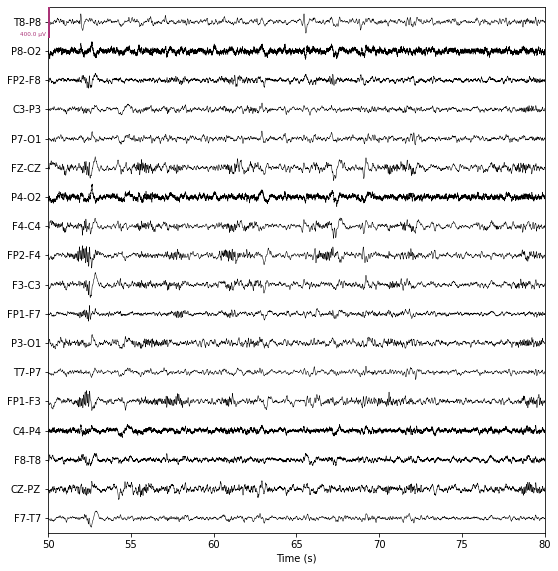

Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


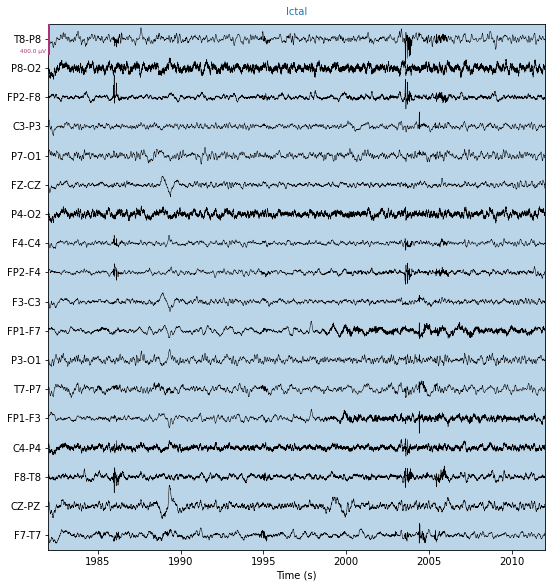

In [14]:
import mne 

def mne_object(data, freq, events = None):
  # create an mne info file with meta data about the EEG
  info = mne.create_info(ch_names=list(data.columns), 
                         sfreq=freq, 
                         ch_types=['eeg']*data.shape[-1])
  
  # data needs to be in volts rather than in microvolts
  data = data.apply(lambda x: x*1e-6)
  # transpose the data
  data_T = data.transpose()
  
  # create raw mne object
  raw = mne.io.RawArray(data_T, info)

  if events:
    start_times = np.array(events[::2])
    end_times = np.array(events[1::2])
    anno_length = end_times-start_times
    event_name = np.array(['Ictal']*len(anno_length))

    raw.set_annotations(mne.Annotations(start_times,
                                      anno_length,
                                      event_name))

  return raw

mne_data = mne_object(raw_data, freq, part_info_dict[EXAMPLE_ID]['Seizures Window'])


mne_data.plot(start = 50, 
              duration = 30, **plot_kwargs);

seiz_start_time = part_info_dict[EXAMPLE_ID]['Seizures Window'][0]
mne_data.plot(start = seiz_start_time, 
              duration = 30, **plot_kwargs);

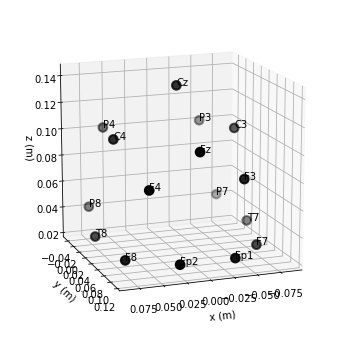

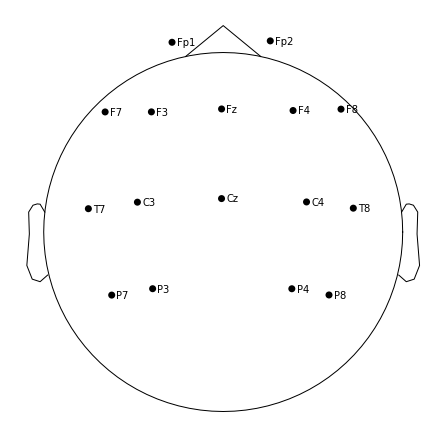

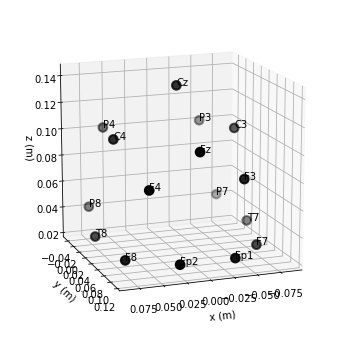

In [16]:
import matplotlib.pyplot as plt

replace_dict = {}
drop_list = []
# for the channel names in the data...
for channel_name in mne_data.info['ch_names']:
    # get the name to change too
    name_change = re.findall('\w+',channel_name)[0].title()
    # check if it is already in the change list
    if name_change in list(replace_dict.values()):
        drop_list.append(channel_name)
    else:
        # if its not already there get the origional name and what we want to 
        # change it to
        replace_dict[channel_name] = name_change

# drop the ones that would be repeats
mne_data.drop_channels(drop_list)
# rename the channels
mne_data.rename_channels(replace_dict)
# set the standard montage
mne_data.set_montage('standard_1020')

mne_data.plot_sensors(kind='topomap', show_names=True, to_sphere=True);
fig = mne_data.plot_sensors(kind='3d', show_names=True, show=False)
fig = fig.gca().view_init(azim=70, elev=15)
plt.show()

<ipython-input-19-dce964a09849>:25: FutureWarning: The "show_names" parameter is deprecated and will be removed in version 1.3. Use the "names" parameter instead.
  vmax = topo_df.values.max())
<ipython-input-19-dce964a09849>:25: FutureWarning: The "vmin" and "vmax" parameters are deprecated and will be removed in version 1.3. Use the "vlim" parameter instead.
  vmax = topo_df.values.max())
<ipython-input-19-dce964a09849>:25: FutureWarning: The "show_names" parameter is deprecated and will be removed in version 1.3. Use the "names" parameter instead.
  vmax = topo_df.values.max())
<ipython-input-19-dce964a09849>:25: FutureWarning: The "vmin" and "vmax" parameters are deprecated and will be removed in version 1.3. Use the "vlim" parameter instead.
  vmax = topo_df.values.max())


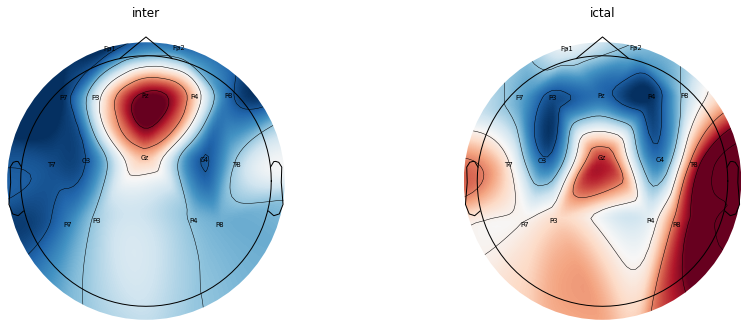

In [19]:
from scipy import signal
def ave_freq(data):
    win = 4 * freq
    freqs, psd = signal.welch(data, freq, nperseg=win, scaling='spectrum')
    #print(freqs[4:160])
    return psd[:,4:160].mean(1)

inter_array = mne_data[:, 50*freq:80*freq][0]
ictal_array = mne_data[:, (seiz_start_time*freq):(seiz_start_time*freq)+30*freq][0]
topo_df = pd.DataFrame([ave_freq(inter_array),ave_freq(ictal_array)], index=['inter', 'ictal'])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs = axs.flatten()
for i, data_class in enumerate(topo_df.T):
    topo, cn = mne.viz.plot_topomap(topo_df.loc[data_class],
                                    mne_data.info,
                                    show=False,
                                    sensors=True,
                                    names=mne_data.info['ch_names'], 
                                    show_names=True,
                                    axes = axs[i],
                                    cmap = 'RdBu_r', 
                                    vmin = topo_df.values.min(),
                                    vmax = topo_df.values.max())
    axs[i].set_title(data_class)
    
plt.show()